<a href="https://colab.research.google.com/github/Samy-Annasri/genetic_algorithm_adv/blob/main/genetic_algorithm_adv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
google_data = pd.read_csv("data/HistoricalData_1747091015337.csv")
google_data['Date'] = pd.to_datetime(google_data['Date'])
google_data = google_data.sort_values(by='Date')

In [13]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
sequence_length = 30
result = prepare_stock_dataset(google_data)

train_loader = result['train_loader']
val_loader = result['val_loader']
test_loader = result['test_loader']
train_size = result['train_size']
val_size = result['val_size']
min_max = result['min_max']
dates = result['dates']
price_min, price_max = min_max['Close/Last']


In [14]:
from utils.train_with_validation import train_model_with_validation
from models.lstm import SimpleLSTM
model_google = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google.parameters(), lr=0.01)
num_epochs = 10
train_model_with_validation(model_google, loss_fn, optimizer, num_epochs, train_loader, val_loader,sequence_length)

Epoch [1/10], Train Loss: 0.1094, Validation Loss: 0.0109
Epoch [2/10], Train Loss: 0.0052, Validation Loss: 0.0010
Epoch [3/10], Train Loss: 0.0017, Validation Loss: 0.0007
Epoch [4/10], Train Loss: 0.0016, Validation Loss: 0.0007
Epoch [5/10], Train Loss: 0.0013, Validation Loss: 0.0006
Epoch [6/10], Train Loss: 0.0012, Validation Loss: 0.0006
Epoch [7/10], Train Loss: 0.0012, Validation Loss: 0.0014
Epoch [8/10], Train Loss: 0.0013, Validation Loss: 0.0008
Epoch [9/10], Train Loss: 0.0012, Validation Loss: 0.0006
Epoch [10/10], Train Loss: 0.0012, Validation Loss: 0.0006


In [15]:
from utils.google_eval import evaluate_model_google
results = evaluate_model_google(model_google, test_loader, dates, train_size, val_size)

real_values = results['real_values']
predicted_values = results['predicted_values']
test_dates = results['test_dates']

In [16]:
# Creation of the tab result for plotting adversial attack result
models = ['LSTM']
metrics = ['MAE', "RSME", 'SIM']

row_index = pd.MultiIndex.from_product([models, metrics], names=['Model', 'Metric'])

attacks = ['NA', 'GEN']
epsilons = {
    'NA': [0],
    'GEN': [0.01, 0.1, 0.2],
}

col_tuples = []
for atk, eps_list in epsilons.items():
    for eps in eps_list:
        col_tuples.append((atk, f"{eps:.2f}"))

col_index = pd.MultiIndex.from_tuples(col_tuples, names=['Attack', 'ε'])

res_tab = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

print(res_tab)

Attack         NA  GEN          
ε            0.00 0.01 0.10 0.20
Model Metric                    
LSTM  MAE     NaN  NaN  NaN  NaN
      RSME    NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN


In [17]:
# Computes scalar similarity (cosine similarity) between true and predicted values.
# Higher values indicate that adversarial predictions remain directionally aligned
# with the true values, suggesting stealthy and rational attacks!
def scalar_similarity(y_true, y_pred):
    numerator = np.dot(y_true, y_pred)
    denominator = np.linalg.norm(y_true) * np.linalg.norm(y_pred)
    if denominator == 0:
        return 0.0
    return numerator / denominator



LSTM | NA – Epsilon 0.00 – MAE: 2.7858 | SIM: 0.9997


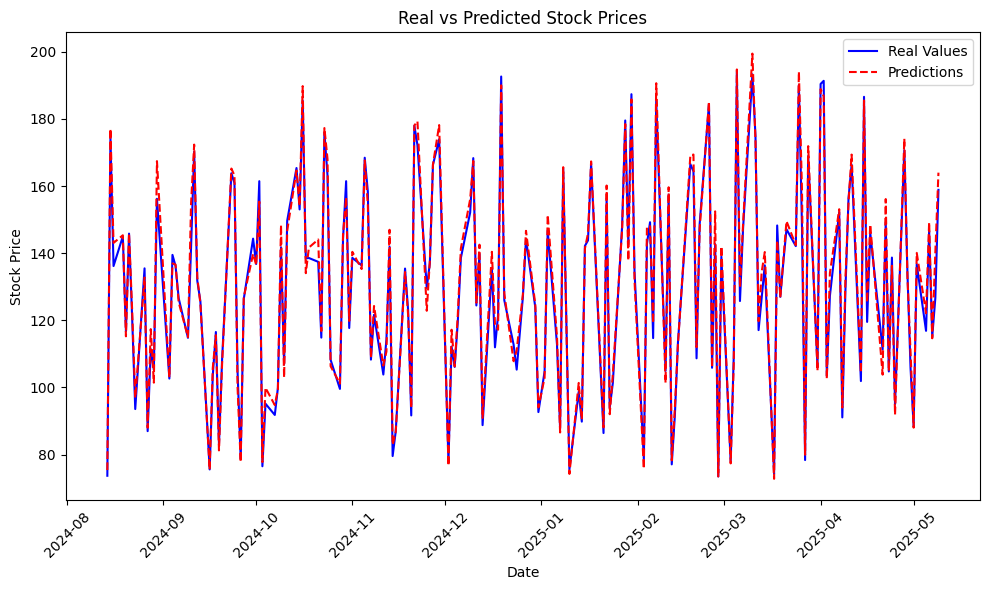

In [18]:
from utils.log_and_plot import log_and_plot_predictions
# Denormalize
true_values_denorm = real_values * (price_max - price_min) + price_min
predictions_denorm = predicted_values * (price_max - price_min) + price_min
mae = mean_absolute_error(true_values_denorm, predictions_denorm)
sim = scalar_similarity(true_values_denorm, predictions_denorm)
rsme = np.sqrt(mean_squared_error(true_values_denorm, predictions_denorm))

log_and_plot_predictions(
    true_values=true_values_denorm,
    predictions=predictions_denorm,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)